# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.66119295217821

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    l = X.shape[0]
    boostrap_results = np.zeros((l, 4))
    all_indices = np.arange(l)
    for j in range(num_runs):
        boostrap_indices = np.random.choice(l, size=l) # сгенерированные бустрапом индексы для j-ой выборки 
        out_of_bag = np.setdiff1d(all_indices, boostrap_indices) # out-of-bag индексы для j-ой выборки
        regressor.fit(X[boostrap_indices, :], y[boostrap_indices]) # обучаем на in-bag индексах
        y_pred = regressor.predict(X[out_of_bag, :]) # предсказываем для out-of-bag индексов
        boostrap_results[out_of_bag, 0] += y_pred
        boostrap_results[out_of_bag, 1] += y_pred ** 2
        boostrap_results[out_of_bag, 2] += np.square(y_pred - y[out_of_bag])
        boostrap_results[out_of_bag, 3] += 1
        
    notnull_indices = boostrap_results[:, 3] > 0 
    average_pred = boostrap_results[notnull_indices, 0] / boostrap_results[notnull_indices, 3] # бэггинг?
    bias = np.square(average_pred - y).mean()
    # делим только на ненулевые (например, эти индексы можно получить с помощью pd.notnull())
    variance = (
       (
        boostrap_results[notnull_indices, 1] / boostrap_results[notnull_indices, 3] - np.square(average_pred)
       ).mean()
    )
    error = (boostrap_results[notnull_indices, 2] / boostrap_results[notnull_indices, 3]).mean() 
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
lin_res = compute_biase_variance(regression, X, y)
print("Linear Regression : bias = {}, variance = {}, error = {}".format(*lin_res))

Linear Regression : bias = 23.760630834752433, variance = 0.9232066000696142, error = 24.68383743482206


In [8]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree_res = compute_biase_variance(tree, X, y)
print("Desicion Tree : bias = {}, variance = {}, error = {}".format(*tree_res))

Desicion Tree : bias = 10.155827969302653, variance = 12.895410864880386, error = 23.051238834183046


In [10]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_res = compute_biase_variance(rf_reg, X, y)
print("Random Forest : bias = {}, variance = {}, error = {}".format(*rf_res))

Random Forest : bias = 10.69083241268213, variance = 2.2565333773113068, error = 12.947365789993475


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ 
Во первых, видно, что для линейной модели, действительно, разброс получается небольшим (оно и логично, все линейные модели графически это линии, а линии просто отличаются наклоном, и то не на очень много), но смещение - достаточно большое, что согласуется с тем, о чем говорили в лекции.
Вероятно, данные просто плохо приближаются линейной моделью. Ошибка линейной модели наибольшая.

У деревьев же видно, что смещение уменьшается (ведь деревья, особенно неограниченные по глубине, хорошо подстраиваются под обучающие данные), но деревья крайне неустойчивы - так что разброс увеличивается более чем в 13 раз по сравнению с линейной моделью.
Т.к. разброс велик, видимо, данные и правда не очень однородные, а значит деревья, построенные на бустрапнутых подвыборках сильно перестраиваются каждый раз.

Лучший результат (по ошибке) выдал RF, что неудивительно - обучается он правда долго, потому что RF это бэггинг над глубокими деревьями с умным выбором признаков для низкой ковариации моделей.
Смещение RF примерно равно смещению DecisionTree's, из которых он построен, а вот разброс сильно уменьшается - почти в 6,5 раз по сравнению с обычным DT.

Таким образом, на практике всё работает как и в теории(как мы говорили в комментарии), и это внушает оптимизм)
И правда, error ~ variance + bias

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Бэггинг позволяет уменьшать разброс (в теории) почти в N раз(где N - кол-во моделей в композиции) при низких значениях ковариации этих моделей(чего на практике не просто добиться, ведь у нас бутрапом генерируются выборки, те данные,на которых обучаем модели -  пересекаются).

На практике я взял стандартный BaggingRegressor из sklearn, у которого всего 10 моделей.

Бэггинг над лин моделями увеличил и разброс, и ошибку, т.е. показал отрицательный прирост полезности. Оно и понятно - у лин моделей и так разброс небольшой,ведь все модели примерно одинаковые,а значит между ними сильная корреляция и смысл у бэггинга на лин моделях примерно нулевой.

Бэггинг над деревьями(почти что рандом форест) показал хорошее снижение разброса (почти в 4 раза), и ошибка уменьшилась на 40%. Итог: бэггинг над деревьями(глубокими) работает хорошо

Бэггинг над Random Forest(бэггинг над бэггингом, выходит) - это не очень здравая идея - смещение увеличилось, разброс упал - -но оба на примерно одну по модулю величину, из-за чего ошибка осталась на том же уровне(даже подросла на 0.003), а еще обучается очень и очень и очень долго

In [9]:
from sklearn.ensemble import BaggingRegressor

In [10]:
bagging_on_linear_res = compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)
print("Linear Regression : bias = {}, variance = {}, error = {}".format(*lin_res))
print("Bagging on Linear Regression : bias = {}, variance = {}, error = {}".format(*bagging_on_linear_res))

Linear Regression : bias = 23.760630834752433, variance = 0.9232066000696142, error = 24.68383743482206
Bagging on Linear Regression : bias = 23.777301360651858, variance = 1.0070253657533734, error = 24.784326726405286


In [11]:
bagging_on_DS_res = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)
print("Linear Regression : bias = {}, variance = {}, error = {}".format(*tree_res))
print("Bagging on Linear Regression : bias = {}, variance = {}, error = {}".format(*bagging_on_DS_res))

Linear Regression : bias = 10.155827969302653, variance = 12.895410864880386, error = 23.051238834183046
Bagging on Linear Regression : bias = 10.574495473522584, variance = 3.372191425271506, error = 13.94668689879412


In [14]:
bagging_on_RF_res = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y)
print("Linear Regression : bias = {}, variance = {}, error = {}".format(*rf_res))
print("Bagging on Linear Regression : bias = {}, variance = {}, error = {}".format(*bagging_on_RF_res))

Linear Regression : bias = 10.69083241268213, variance = 2.2565333773113068, error = 12.947365789993475
Bagging on Linear Regression : bias = 11.54314684203284, variance = 1.4097989485845708, error = 12.95294579061742


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_indices = np.random.choice(X.shape[0], num_test_objects)
    out_of_bag_mask = np.ones(X.shape[0])
    out_of_bag_mask[test_indices] = 0
    train_indices = out_of_bag_mask.nonzero()[0]
    
    X_train, y_train, X_test, y_test = X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices]
    
    results = np.zeros((num_runs, num_test_objects))
    for i in range(num_runs):
        indices = np.random.choice(X_train.shape[0], X_train.shape[0])
        regressor.fit(X_train[indices, :], y_train[indices])
        results[i, :] = regressor.predict(X_test)
    
    plt.scatter([[i] for i in range(num_test_objects)] * num_runs, results, c='cyan')
    plt.scatter([[i] for i in range(num_test_objects)], y_test, c='black')
    #plt.scatter([[i] for i in range(num_test_objects)] * num_runs, predictions, c='cyan')
    #plt.scatter([[i] for i in range(num_test_objects)], y_test, c='black')
    
    plt.title(title)
    plt.xlabel('Index of test object')
    plt.ylabel('Target value')
    

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

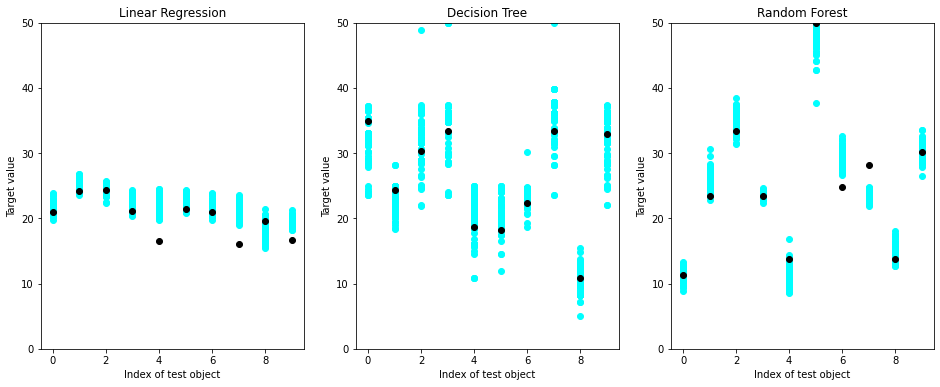

In [16]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.ylim(0, 50)
plot_predictions(LinearRegression(), X, y, title="Linear Regression")

plt.subplot(1, 3, 2)
plt.ylim(0, 50)
plot_predictions(DecisionTreeRegressor(), X, y, title="Decision Tree")

plt.subplot(1, 3, 3)
plt.ylim(0, 50)
plot_predictions(RandomForestRegressor(n_jobs=-1), X, y, title="Random Forest")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Для 1 графика отчетливо видно, что на 6/10 объектах черная точка(истинное значение) вообще не лежит на голубых линиях(множество предсказаний), это вызвано сильным смещений линейных моделей. При это длины самих полосок не очень большие - на 8/10 объектах около 5 у.е.

Для графика 2 характерно хорошая точность - все черные точки лежат в наших голубых полосках, но сами полоски с выбросами и очень вытянутые - это же деревья, разброс и правда большой.

Для графика 3 видно, что почти везде разброс уменьшился относительно графика 2, при этом смещение почти не пострадало.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [17]:
### your code here
max_depth = 10
max_features = X.shape[1]

In [18]:
variance, bias = np.zeros((max_depth, max_features)), np.zeros((max_depth, max_features))
for depth in range(1, max_depth + 1):
    for n_feature in range(1, max_features + 1):
        result = compute_biase_variance(DecisionTreeRegressor(max_depth=depth, max_features=n_feature), X, y)
        variance[depth - 1, n_feature - 1], bias[depth - 1, n_feature - 1] = result[1], result[0] 

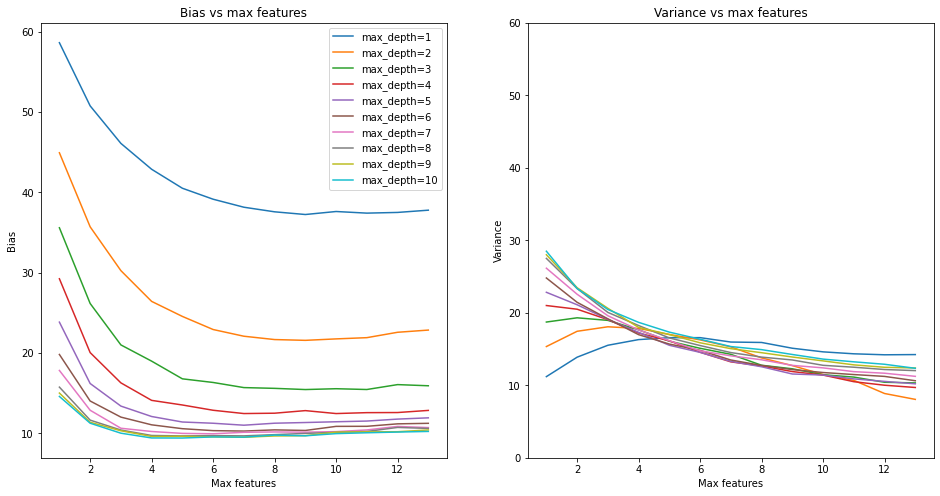

In [19]:
n_features = np.linspace(1, max_features, max_features, dtype=int)
depths = np.linspace(1, max_depth, max_depth, dtype=int)
f = plt.figure(figsize=(16, 8), sharey=True)

plt.subplot(1, 2, 1)
plt.title('Bias vs max features')
plt.xlabel('Max features')
plt.ylabel('Bias')
for index in range(max_depth):
    plt.plot(n_features, bias[index, :], label='max_depth={}'.format(depths[index]))

plt.legend()
    
plt.subplot(1, 2, 2)
plt.ylim(0, 60)
plt.title('Variance vs max features')
plt.xlabel('Max features')
plt.ylabel('Variance')
for index in range(max_depth):
    plt.plot(n_features, variance[index, :], label='max_depth={}'.format(depths[index]))
    
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [22]:
### your code here
from sklearn.ensemble import GradientBoostingRegressor

var_for_rf, var_for_gb = np.zeros(9), np.zeros(9)
bias_for_rf, bias_for_gb = np.zeros(9), np.zeros(9)

n_estimators = 2 ** np.arange(1, 10)
for i in range(n_estimators.shape[0]):
    res_for_rf = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators[i]), X, y)
    res_for_gb = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators[i]), X, y)
    bias_for_rf[i], var_for_rf[i] = res_for_rf[0], res_for_rf[1]
    bias_for_gb[i], var_for_gb[i] = res_for_gb[0], res_for_gb[1]

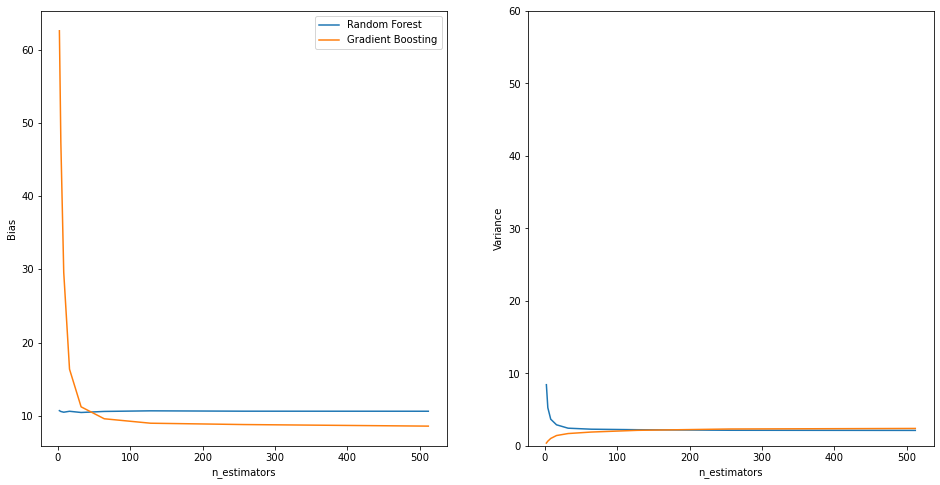

In [26]:
f = plt.figure(figsize=(16, 8))
plt.title("RandomForest vs GradientBoosting")

plt.subplot(1, 2, 1)
plt.xlabel("n_estimators")
plt.ylabel("Bias")
plt.plot(n_estimators, bias_for_rf, label="Random Forest")
plt.plot(n_estimators, bias_for_gb, label="Gradient Boosting")

plt.legend()

plt.subplot(1, 2, 2)
plt.ylim(0,60)
plt.xlabel("n_estimators")
plt.ylabel("Variance")
plt.plot(n_estimators, var_for_rf, label="Random Forest")
plt.plot(n_estimators, var_for_gb, label="Gradient Boosting")

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

_*Первый график:*_

Видно, что примерно до глубины равной 4-5 идет равномерное(монотонное) убывание смещения до 10 признаков. Это вполне себе объясняется мы же строим дерево - оно хорошо подстраивается под данные, а чем "больше" (в разных смыслах) оно - тем точнее. Но деревья с какого то момента начинают переобучаться - и этот момент хорошо заметен - начиная с глубины дерева 6, смещение сначала падает где-то до 4-8 признаков(в зависимости от глубины, чем больше глубина - тем меньше признаков нужно чтобы переобучиться), а дальше начинает даже расти, что свидетельствует об переобучении.

_*Второй график*_

Первое, что бросается в глаза - для глубоких деревьев с 1 признаком разброс больше, чем для неглубоких - опять таки подтвеждается этот баланс разброса и смещения. Для глубоких деревьев разброс постоянно уменьшается, для неглубоких сначала растет, потом стабилизируется или вовсе опять падает.

В целом, по первым двум графикам можно сделать вывод, что деревья с глубиной 4-5 и даже 11 признаками ведут себя лучше всех - у них и достигается этот баланс, и не достигается переобучения.

_*Третий график*_

Видно, что если в ансамбле мало базовых моделей, то у градиентного бустинга огромное смещение (ведь в этом случае у нас всего несколько неглубоких деревьев), но начиная с какого-то количества моделей уменьшение смещения прекращается
У RandomForest наоборот, идет очень плавный и медленный рост смещения. И начинаем мы с маленького значения(оно логично - у нас базовые модели - глубокие деревья), к тому же бэггинг не меняет смещение.

Оба графика (для RF и для GB) пересекаются где то на количестве моделей равном 50, при отметеке смещения около 12.

_*Четвертый график*_

Во первых, видно, что на графике смещения у бустинга при малом количестве смещение примерно 50-60, а на графике разброса - почти что ноль. По мере увеличения количества моделей разброс GB только растет,ведь каждое следующее дерево дает всё меньший вклад. А вот RF быстро уменьшает разброс из-за низкой корреляции деревьев, а потом стабилизируется.


В этот раз, графики для двух моделей пересекаются на отметке n_estimatores около 150.

